In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [46]:
#load data_tanque.csv
data_tanque = pd.read_csv('../datos estanque/datos sin falla/18s_10m2.csv')[1:]

data_tanque.head()

,tiempo,referencia,hc,f_pid
1,1,40,40.000001,85.8
2,2,40,40.000001,85.8
3,3,40,40.000001,85.8
4,4,40,40.000001,85.8
5,5,40,40.000001,85.8


In [47]:
#sample data linearly by 2 rows till 20000 rows
df = data_tanque.copy()
sampling_time = 18
df = df[::sampling_time]

In [48]:
df.head(10)

,tiempo,referencia,hc,f_pid
1,1,40,40.000001,85.800000
19,19,40,42.840644,0.067750
37,37,40,41.515248,0.000000
55,55,40,39.946439,0.000000
73,73,40,38.361845,0.175263
91,91,40,36.661294,3.574307
109,109,40,34.863604,7.224764
127,127,40,32.940922,11.086463
145,145,40,31.118876,15.219318
163,163,40,29.016977,19.139561


Text(0.5, 1.0, 'referencia y hc en funcion del tiempo')

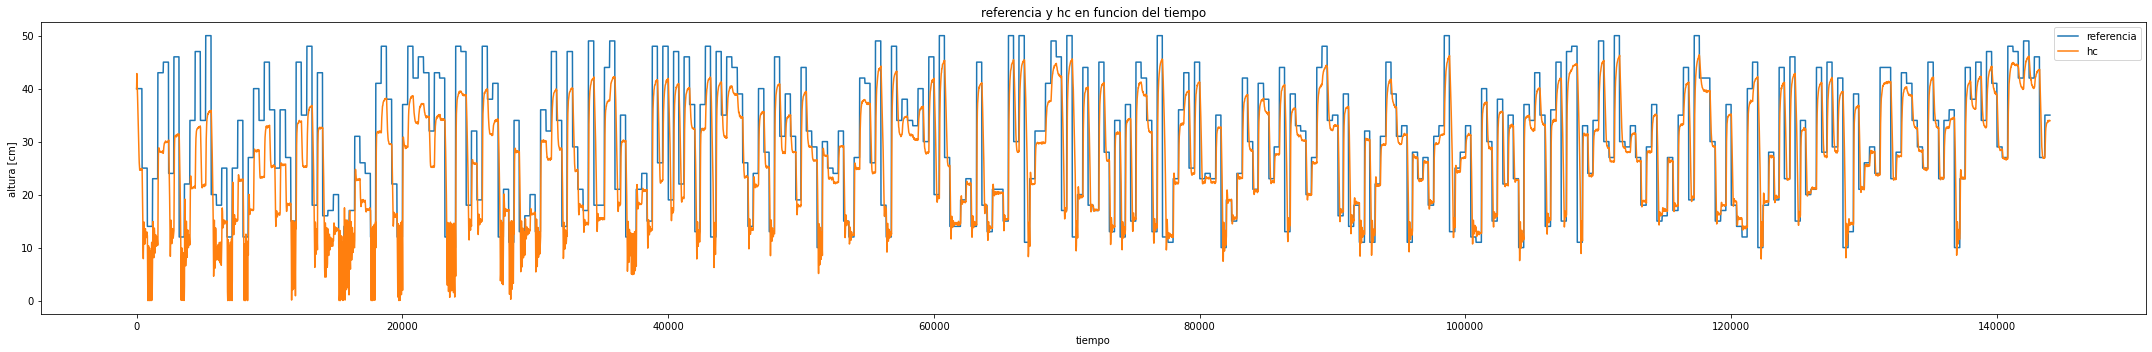

In [49]:
#graficar los referencia y hc en funcion del tiempo
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'], df['referencia'], label='referencia')
plt.plot(df['tiempo'], df['hc'], label='hc')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('referencia y hc en funcion del tiempo')

(0.0, 3600.0)

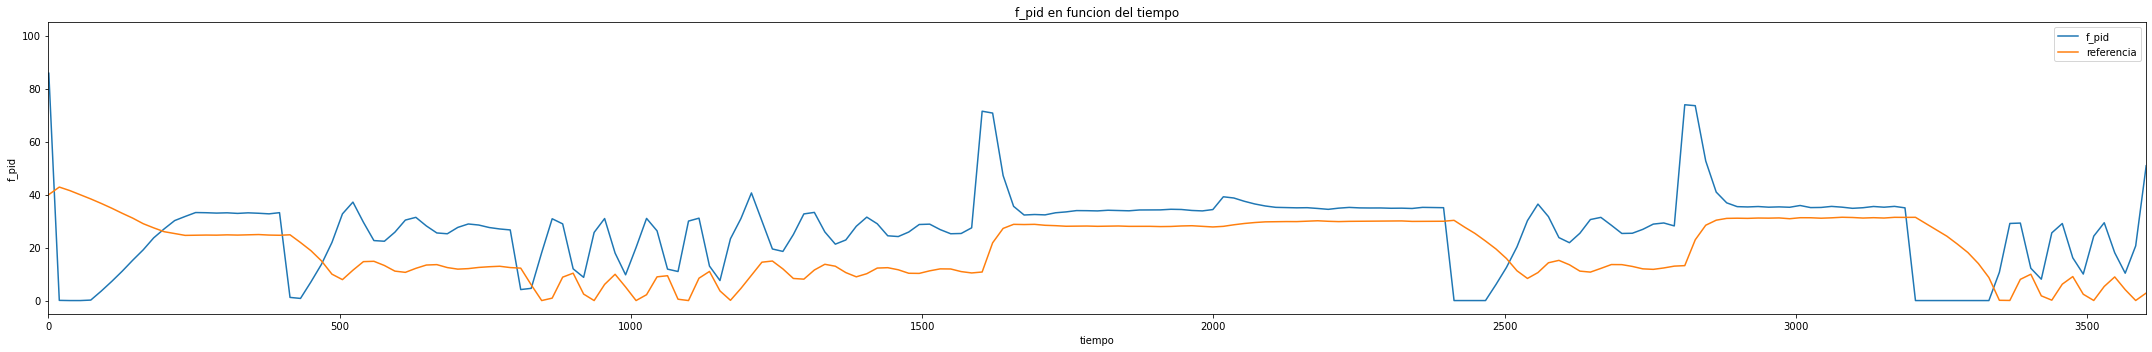

In [54]:
#plot f_pid
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'], df['f_pid'], label='f_pid')
plt.plot(df['tiempo'], df['hc'], label='referencia')
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('f_pid')
plt.title('f_pid en funcion del tiempo')
plt.xlim(0, 3600)

# RED MLP

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.is_available() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [56]:
df['hc'].shift(1).diff(1).to_numpy()

array([        nan,         nan,  2.84064331, ...,  0.08927481,
       -0.0312168 , -0.02906546])

In [226]:
#train set: 12 hours
step = int(40*3600/sampling_time)

X_train = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:step],
                                     
                                     df['f_pid'].shift(1).to_numpy()[2:step],
                                    ))).T).float()


y_train = torch.from_numpy(((df['hc'].to_numpy()[2:step]))).float()


#create validation data since 12 hours to the end:

X_valid = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[step:],
                                     df['f_pid'].shift(1).to_numpy()[step:],
                                     ))).T).float()
                                      
y_valid = torch.from_numpy(((df['hc'].to_numpy()[step:]))).float()


#test data
data_tanque = pd.read_csv('../datos estanque/datos sin falla/18s_10m2_test.csv')[1:]
data_tanque.head()
df_test = data_tanque.copy()
sampling_time = 18
df_test = df_test[::sampling_time]

#DEfine X_test and y_test
X_test = torch.from_numpy(np.vstack(((df_test['hc'].shift(1).to_numpy()[2:],
                                     
                                     df_test['f_pid'].shift(1).to_numpy()[2:],
                                    #  df['freq_prev_prev'].to_numpy(),
                                    #  df['freq_prev_3'].to_numpy(),
                                    #  df['freq_prev_4'].to_numpy(),
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df_test['hc'].to_numpy()[2:]))).float()
y_test = y_test.to(device)



In [202]:
#naive prediction
from sklearn.metrics import mean_squared_error
y_pred_naive = (df_test['hc'].shift(1)[1:].values)
#replace nans by 0
y_pred_naive[np.isnan(y_pred_naive)] = 0
mean_squared_error((df_test['hc'][1:].values), y_pred_naive)

3.0797146938933477

In [203]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_valid = X_valid.to(device)
y_valid = y_valid.to(device)

In [205]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
    

In [218]:
#cross validation
from sklearn.model_selection import KFold
model = MLP()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

loss_curve_train = [np.inf]
loss_curve_valid = [np.inf]
saved_loss = np.inf 

epochs = 3000
kfold = KFold(n_splits=5, shuffle=True)

for epoch in range(epochs):
    mean_loss_val = 0
    mean_loss_train = 0
    for train_index, valid_index in kfold.split(X_train):
        X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
        y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

        model.train()
        y_pred = model(X_train_cv)
        loss = loss_fn(y_pred.squeeze(), y_train_cv)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #validation
        model.eval()
        y_pred_val = model(X_valid_cv)
        loss_val = loss_fn(y_pred_val.squeeze(), y_valid_cv)
        mean_loss_val += loss_val.item()
        mean_loss_train += loss.item()
    mean_loss_val = mean_loss_val/5
    mean_loss_train = mean_loss_train/5

    loss_curve_train.append(mean_loss_train)
    loss_curve_valid.append(mean_loss_val)

    # save best model
    if mean_loss_train <= min(loss_curve_train) and (mean_loss_val <= min(loss_curve_train) or mean_loss_val <= min(loss_curve_valid)):
        print('saving model...')
        saved_i = epoch
        torch.save(model.state_dict(), '../modelos torch/18s_v5.pth')
        print('Model saved')
    # loss_curve_train.append(loss.item())
    # loss_curve_valid.append(loss_val.item())
    print('Epoch: {}, Loss validation: {:.4f}, Loss train: {:.4f}'.format(epoch, mean_loss_val, mean_loss_train))
print(f'last epoch saved {saved_i}')

saving model...
Model saved
Epoch: 0, Loss validation: 439.1923, Loss train: 505.6914
saving model...
Model saved
Epoch: 1, Loss validation: 182.4296, Loss train: 225.2625
saving model...
Model saved
Epoch: 2, Loss validation: 45.2888, Loss train: 61.7980
saving model...
Model saved
Epoch: 3, Loss validation: 35.0196, Loss train: 30.0478
Epoch: 4, Loss validation: 50.9767, Loss train: 51.7304
Epoch: 5, Loss validation: 27.5041, Loss train: 32.7186
saving model...
Model saved
Epoch: 6, Loss validation: 13.4456, Loss train: 14.2330
Epoch: 7, Loss validation: 14.5883, Loss train: 14.2646
saving model...
Model saved
Epoch: 8, Loss validation: 12.7559, Loss train: 13.6215
saving model...
Model saved
Epoch: 9, Loss validation: 7.7317, Loss train: 8.5965
saving model...
Model saved
Epoch: 10, Loss validation: 5.9434, Loss train: 6.0625
saving model...
Model saved
Epoch: 11, Loss validation: 5.5622, Loss train: 5.7270
saving model...
Model saved
Epoch: 12, Loss validation: 4.0568, Loss train: 

In [219]:
loss_curve_train[saved_i]

0.03148119784891605

In [220]:
loss_curve_valid[saved_i]

0.031105922535061836

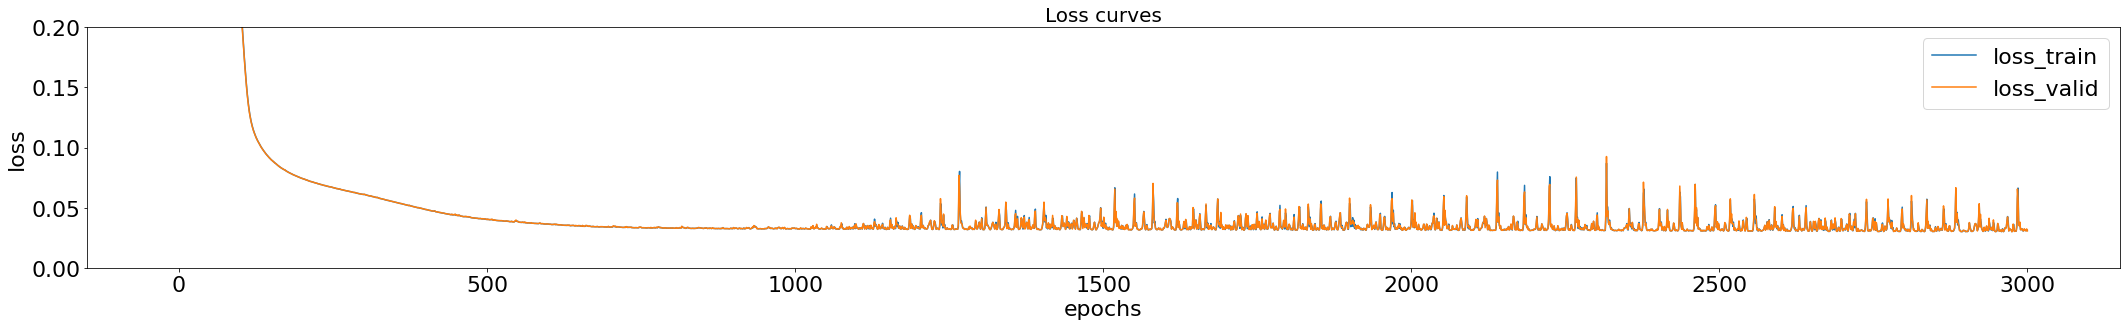

In [222]:
#plot loss curves (lmao what a noisy curves lol)


plt.figure(figsize=(30,5))
plt.plot(loss_curve_train[:], label='loss_train')
plt.plot(loss_curve_valid[:], label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.xlim(150, 1000)
# plt.ylim(0, 0.04)
#increment font size and legend size
plt.legend(fontsize=20)
plt.title('Loss curves', fontsize=20)
plt.rcParams.update({'font.size': 22})
plt.ylim(0, 0.2)
plt.legend()

In [44]:
#create a rnn model with the same parameters
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(4, 200, 1, batch_first=True)
        self.fc = nn.Linear(200, 1)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x
        

In [ ]:
#train model with early stopping
model = RNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loss_curve_train = [np.inf]
loss_curve_valid = [np.inf]
epochs = 5000
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train.unsqueeze(1))
    loss = loss_fn(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #validation
    model.eval()
    y_pred_val = model(X_valid.unsqueeze(1))
    loss_val = loss_fn(y_pred_val.squeeze(), y_valid)

    # save best model
    if loss.item() < min(loss_curve_train) and loss_val.item() < min(loss_curve_valid):
        print('saving model...')
        torch.save(model.state_dict(), '../modelos torch/RNN_tanque_referencia_fija_5s.pt')
        print('Model saved')
    
    loss_curve_train.append(loss.item())
    loss_curve_valid.append(loss_val.item())

    print('Epoch: {}, Loss validation: {:.4f}, Loss train: {:.4f}'.format(epoch, loss_val.item(), loss.item() ))

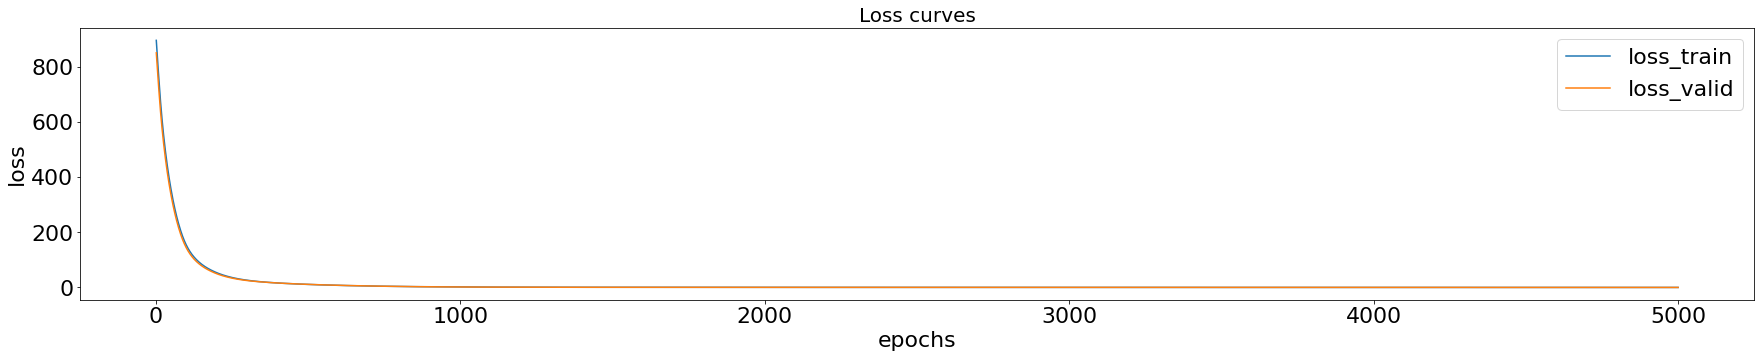

In [223]:
#plot loss curves (lmao what a noisy curves lol)


plt.figure(figsize=(30,5))
plt.plot(loss_curve_train[:], label='loss_train')
plt.plot(loss_curve_valid[:], label='loss_valid')
plt.xlabel('epochs')
plt.ylabel('loss')

# plt.xlim(150, 1000)
# plt.ylim(0, 0.04)
#increment font size and legend size
plt.legend(fontsize=20)
plt.title('Loss curves', fontsize=20)
plt.rcParams.update({'font.size': 22})

plt.legend()

In [223]:
#load model
model = MLP()
model.load_state_dict(torch.load('../modelos torch/18s_v5.pth'))
model.to(device)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): ReLU()
  )
)

In [227]:
#test model
model.eval()
y_pred = model(X_test)
#to cpu
y_pred = y_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

loss = mean_squared_error(y_pred[2:], y_test[2:])
print('Loss test: {:.4f}'.format(loss.item()))


Loss test: 0.0258


Text(0, 0.5, 'hc')

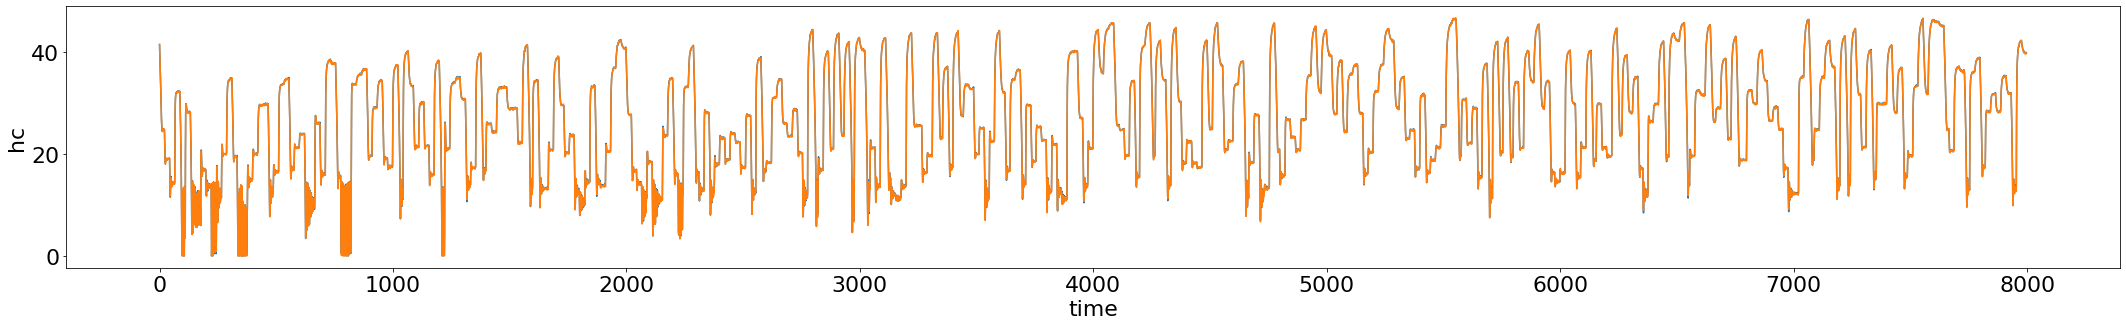

In [228]:
#plot y_test and y_pred
#to cpu
# y_pred = y_pred.cpu().detach().numpy()
# y_test = y_test.cpu().detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.xlabel('time')
plt.ylabel('hc')


In [229]:
# test on another set... same as previous
data_tanque = pd.read_csv('../datos estanque/datos con falla/18s_10m2_fin.csv')[1:]
data_tanque.head()
df = data_tanque.copy()
sampling_time = 18
df = df[::sampling_time]
#create a new column with the previous value of hc



#DEfine X_test and y_test
step = 1
X_test = torch.from_numpy(np.vstack(((df['hc'].shift(1).to_numpy()[2:],
                                     df['f_pid'].shift(1).to_numpy()[2:],
                                     ))).T).float()
X_test = X_test.to(device)
y_test = torch.from_numpy(((df['hc'].to_numpy()[2:]))).float()
y_test = y_test.to(device)


In [230]:
#calc y_hat
y_hat = model(X_test)
#to cpu
y_hat = y_hat.cpu()

#deatch
y_hat = y_hat.detach().numpy()

#flat
y_hat = y_hat.flatten()


In [231]:
#calculate mse
mean_squared_error(y_hat[1:3600], y_test[1:3600].cpu())


0.026298827

In [232]:
#calculate mse
mean_squared_error(y_hat[-3600:-1], y_test[-3600:-1].cpu())


0.11366646

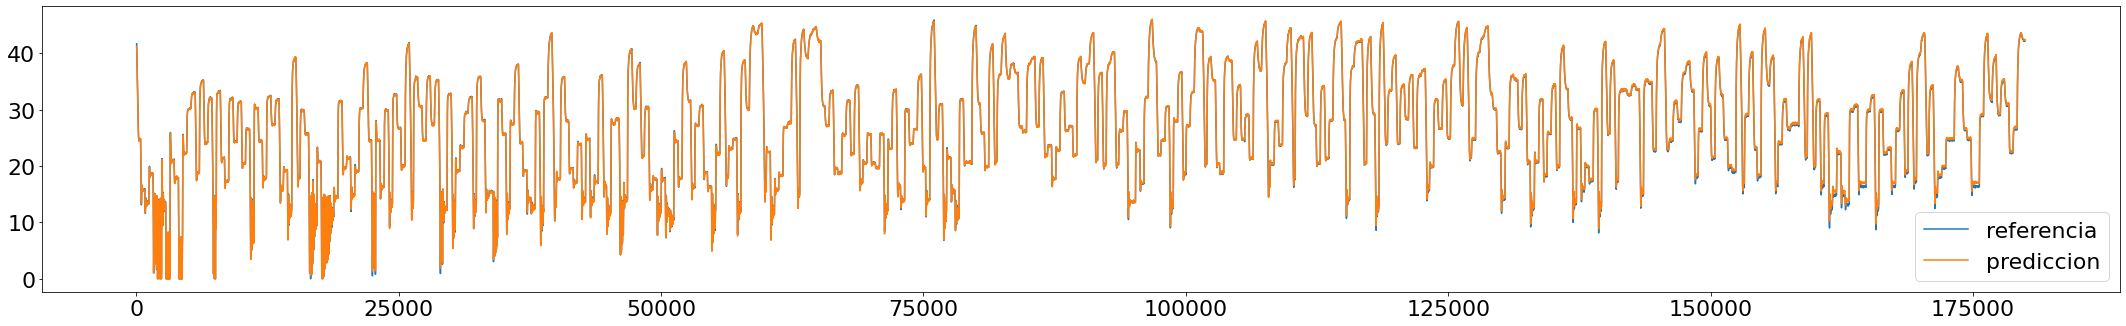

In [233]:
#plot the prediction and referencia
step = 2
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc'][step:].shift(0), label='referencia')
plt.plot(df['tiempo'][step:], pd.Series(y_hat).shift(0), label='prediccion')
plt.legend()
# plt.xlim(36000+3600*6, 36100+3600*6)

#TODO SATMODELS ARMODEL
#V. EXOGENAS.


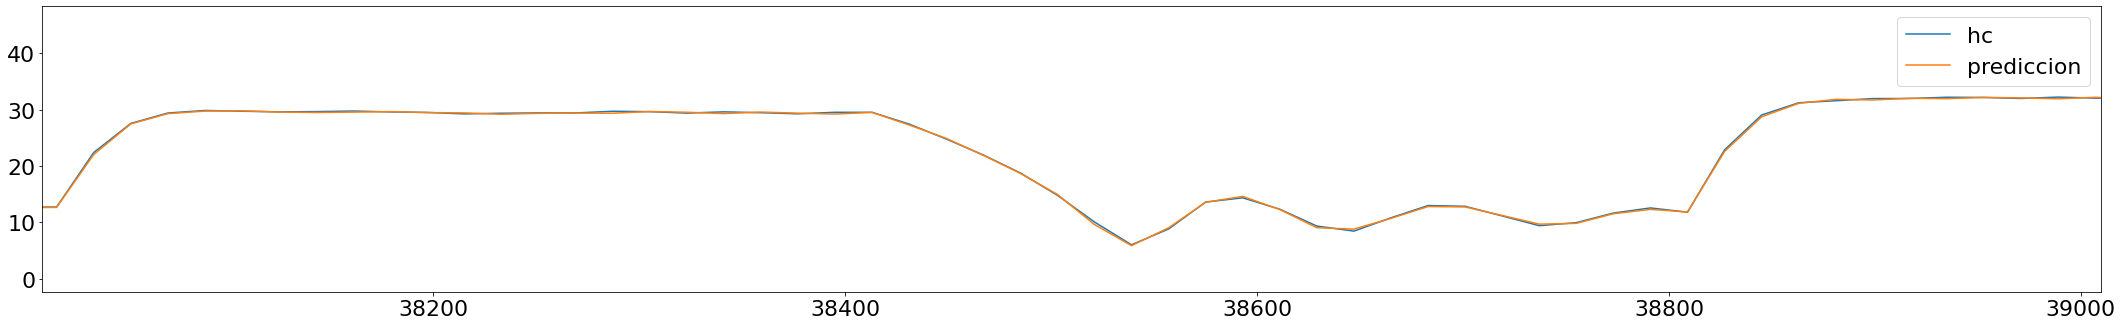

In [234]:
# snapshot of the interval [1000-1100]
step=2
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc'][step:].shift(0), label='hc')
plt.plot(df['tiempo'][step:], y_hat, label='prediccion')
i=10
plt.xlim(3800*i+10, 3900*i+10)
# plt.ylim(5, 25)
plt.legend()


In [1101]:
step

15

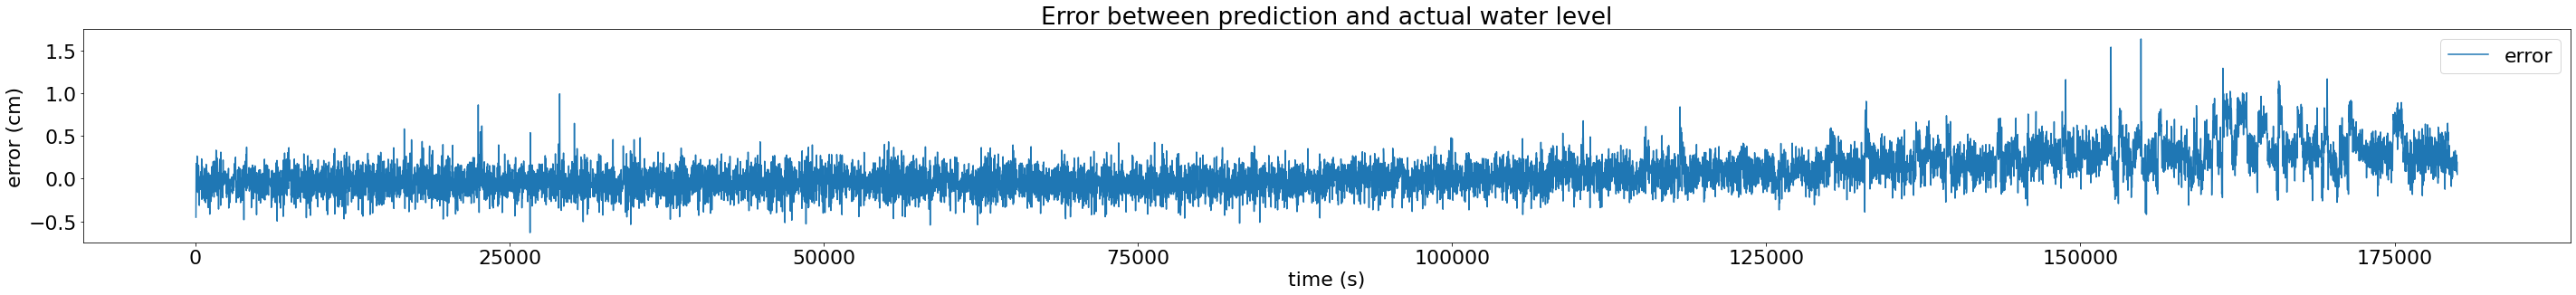

In [235]:
#plot error between prediction and actual hc
step = 2
plt.figure(figsize=(40,5))
plt.plot(df['tiempo'][step:], (y_hat - df['hc'][step:].shift(0)).rolling(int(1)).mean(), label='error')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('error (cm)')
plt.title('Error between prediction and actual water level')
# plt.xlim(72000, 73000)
plt.show()


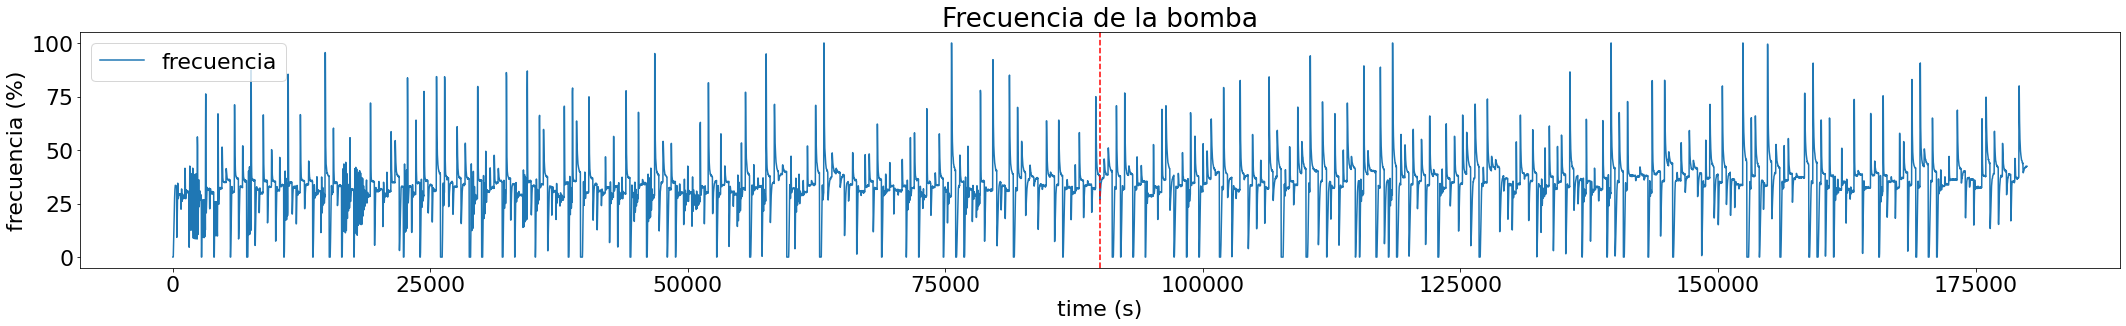

In [236]:
#plot frequency
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['f_pid'][step:].shift(0).rolling(1).mean(), label='frecuencia')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('frecuencia (%)')
plt.title('Frecuencia de la bomba')
#draw a line at x = 36000
plt.axvline(x=90000, color='r', linestyle='--')
plt.show()


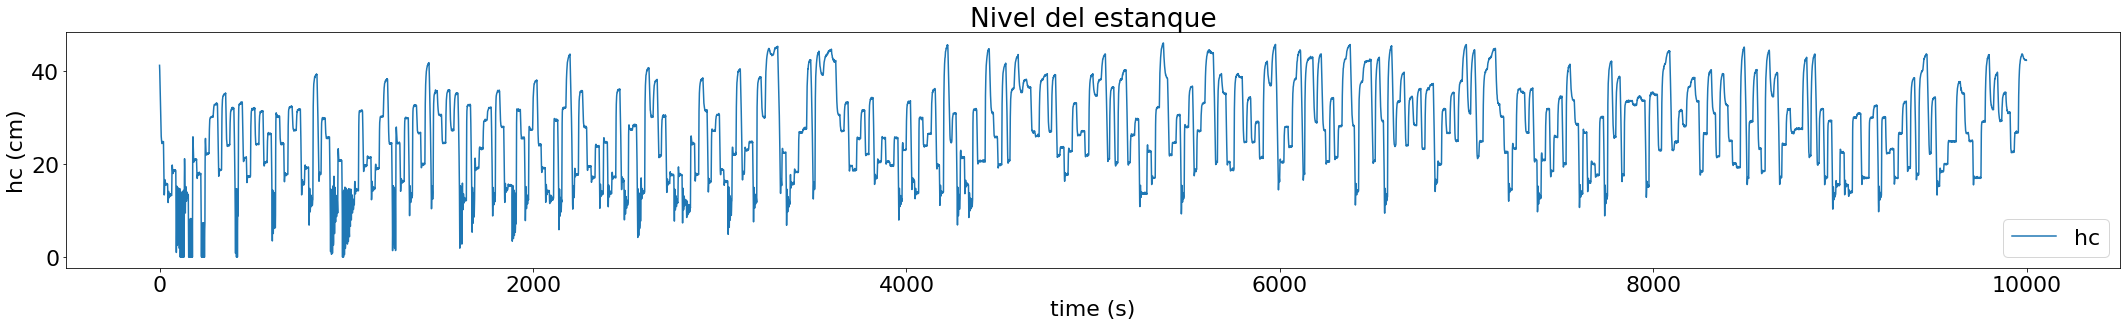

In [237]:
#plot hc
plt.figure(figsize=(30,5))
plt.plot(pd.Series(y_hat).rolling(1).mean(), label='hc')
plt.rcParams.update({'font.size': 22})
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('hc (cm)')
#resize font
plt.title('Nivel del estanque')
plt.show()


In [1280]:
y_hat

array([24.858414, 27.892103, 28.232204, ..., 21.217924, 21.050968,
       21.336823], dtype=float32)

In [1939]:
df['hc'][2:]

37        41.692119
55        39.967184
73        38.326629
91        36.631552
109       35.010069
            ...    
179911    42.299899
179929    42.179692
179947    42.208542
179965    42.173322
179983    42.284664
Name: hc, Length: 9998, dtype: float64

In [81]:
#calculate hc dot
df['hc_dot'] = df['hc'].diff(1)



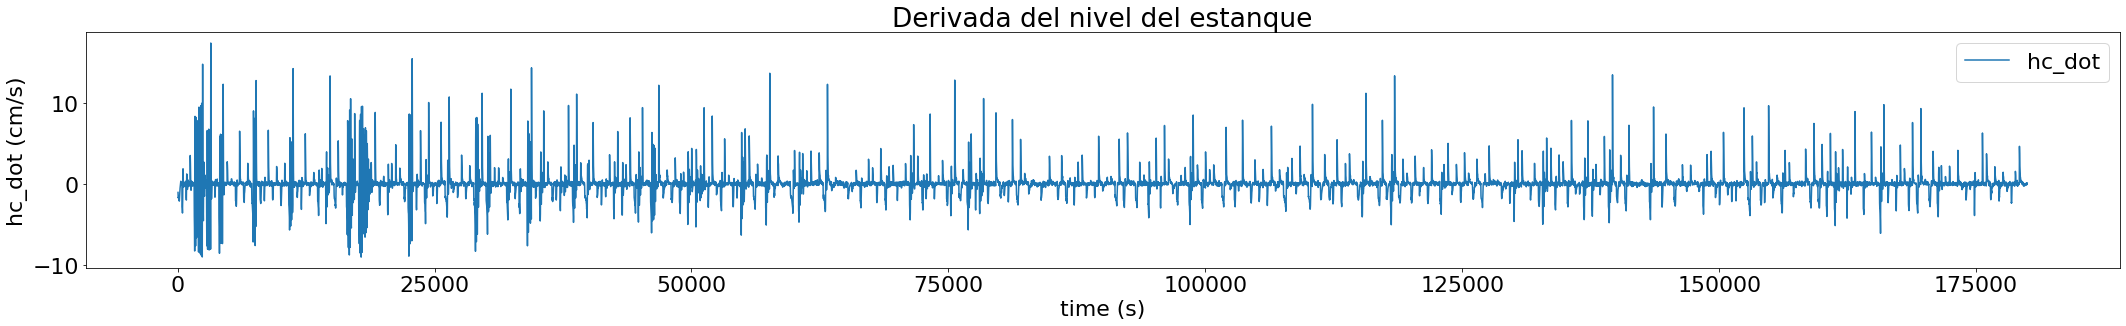

In [82]:
#plot hc_dot
step = 2
plt.figure(figsize=(30,5))
plt.plot(df['tiempo'][step:], df['hc_dot'][step:].shift(0).rolling(1).mean(), label='hc_dot')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('hc_dot (cm/s)')
plt.title('Derivada del nivel del estanque')
plt.show()


In [1917]:
50/3

16.666666666666668

In [1915]:
3600/18*3

600.0

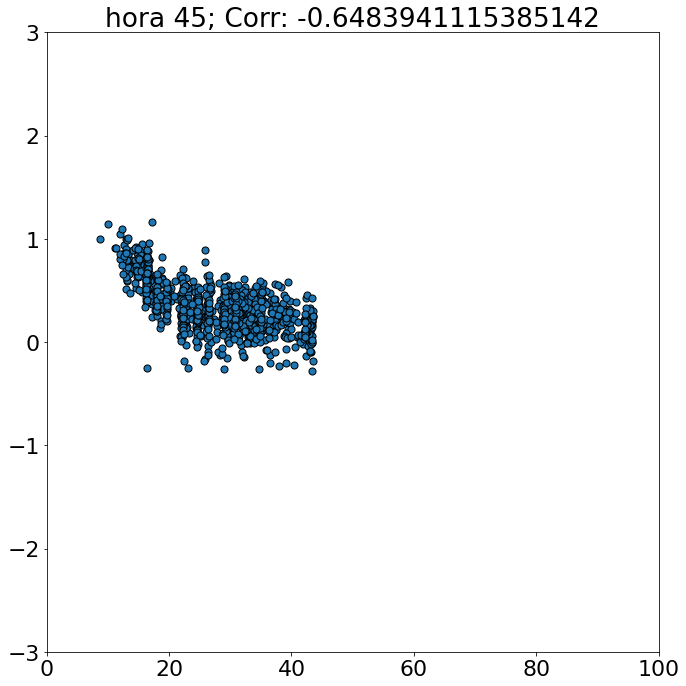

In [238]:
import matplotlib.animation as animation

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

e_s = []
y_s = []
corrs = []
step = 18
steps = 10

for i in range(steps):
    window = int(3600*5/step)
    #normalize h
    #normalize error
    # error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
    start = int(3600*5*i/step)
    
    error_plot = (y_hat - df['hc'][2:].shift(0))[start:start+window]
    hc_plot = df['hc'][2:].shift(1)[start:start+window]
    
    corr = np.corrcoef(hc_plot[1:], error_plot[1:])[0,1]
    corrs.append(corr)

    e_s.append(error_plot)
    y_s.append(hc_plot)

fig, ax = plt.subplots()
marker_size = 50

def animate(i):
   fig.clear()
   ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 100), ylim=(-3, 3))
   ax.set_xlim(0, 100)
   ax.set_ylim(-3, 3)
   ax.set_title(f'hora {5*i}; Corr: ' + str(corrs[i]))
   s = ax.scatter(y_s[i], e_s[i],s=marker_size, cmap="RdBu_r", marker="o", edgecolor='black')

plt.grid(visible=None)
ani = animation.FuncAnimation(fig, animate, interval=500, frames=range(steps))

ani.save(f'../gifs/animation_{str(step)}s_fin_fpid_v2.gif', writer='pillow')

In [1564]:
960*15/3600

4.0

In [1718]:
#dinamic scatter plot of the error vs actual hc
corrs = []
step = 5
for i in range(25):
    window = int(3600*2/step)
    #normalize hc
    #normalize error
    # error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
    start = int(3600*2*i/step)
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    error_plot = (y_hat - df['hc'][2:].shift(0))[start:start+window]
    hc_plot = ((df['hc'][2:]).shift(1)[start:start+window])
    plt.scatter(hc_plot, error_plot, alpha=0.9,s=2)
    # plt.scatter(hc_norm[:window], error_norm[:window], s=10)
    #resize font
    #estimate correlation
    corr = np.corrcoef(hc_plot[1:], error_plot[1:])[0,1]
    corrs.append(corr)
    plt.title(f'Hora {i*2} Correlation: ' + str(corr))
    # plt.xlabel('f_pid (Hz)')
    plt.ylabel('error (cm)')
    # plt.title('Error vs actual water level')
    # plt.xlim(0,50)
    # # plt.ylim(-10,10)
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'shift'

<Figure size 360x360 with 0 Axes>

In [1821]:
x

array([ 0.        ,  5.71428571, 11.42857143, 17.14285714, 22.85714286,
       28.57142857, 34.28571429, 40.        ])

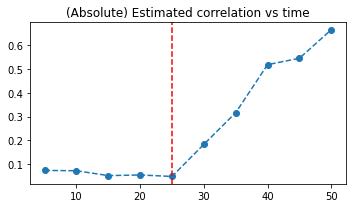

In [163]:
x = np.linspace(5, 50, 10)
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 10})
plt.plot(x, np.abs(corrs), label='correlation', linestyle='--', marker='o')
plt.title('(Absolute) Estimated correlation vs time')
plt.axvline(x=25, color='r', linestyle='--')

In [1356]:
df[:][2:]

,tiempo,referencia,hc,f_pid,hc_dot
20,20,40,29.132417,32.832530,4.132416
30,30,40,28.774452,23.279197,-0.357964
40,40,40,27.640519,23.432146,-1.133934
50,50,40,27.716343,27.011174,0.075824
60,60,40,27.450692,27.920567,-0.265651
...,...,...,...,...,...
179960,179960,20,19.889155,43.578447,0.066337
179970,179970,20,19.971251,44.319729,0.082096
179980,179980,20,19.864492,43.161825,-0.106760
179990,179990,20,20.179165,43.966696,0.314674


In [103]:
#export csv with y_hat
df_export = df[:][2:].copy()
df_export['y_hat'] = y_hat
df_export.to_csv('../outputs modelo/new/18s_fin.csv', index=False)



In [ ]:
#dinamic scatter plot of the error vs actual hc
step = 5
window = int(3600*1/step)
start = int(3600*10/step+100)



plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
error_plot = (pd.Series(y_hat[::step]).diff(1) - pd.Series(df['hc'][::step].shift(1)).diff(1).reset_index(drop=True))[start:start+window]
hc_plot = ((df['hc'][::step]).shift(1)[start:start+window])
plt.scatter(hc_plot, error_plot, alpha=0.5,s=1)

plt.title('Correlation: ' + str(np.corrcoef(hc_plot[:window], error_plot[:window])[0,1]))
plt.ylabel('error (cm)')
plt.show()

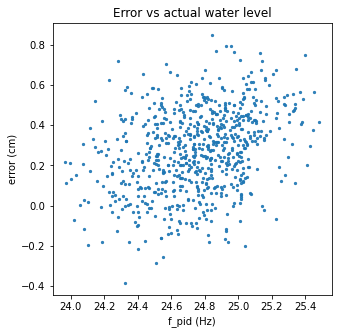

In [599]:
#dinamic scatter plot of the error vs actual hc
step = 5
window = int(3600*1/step)
#normalize hc
#normalize error
# error_norm = ((y_hat - df['hc'][step:]).rolling(window).mean() - (y_hat - df['hc'][step:]).rolling(window).mean().min())/( (y_hat - df['hc'][step:]).rolling(window).mean().max() - (y_hat - df['hc'][step:]).rolling(window).mean().min())
start = int(3600*30/step)
plt.figure(figsize=(5,5))
plt.scatter((df['hc'][::step].shift(1)[start:start+window]), (y_hat[::step] - df['hc'][::step].shift(0))[start:start+window], alpha=0.9,s=5)
# plt.scatter(hc_norm[:window], error_norm[:window], s=10)
#resize font
plt.xlabel('f_pid (Hz)')
plt.ylabel('error (cm)')
plt.title('Error vs actual water level')
# plt.rcParams.update({'font.size': 10})
plt.show()

In [610]:
#export dataframe with y_hat
df['y_hat'] = y_hat
df.to_csv('../outputs modelo/new/df.csv')


# TESTEO EN FALLA

In [189]:
# model = MLP()
# model.load_state_dict(torch.load('../modelos torch/model_tanque_referencia_fija_5s.pt'))
# model.to(device)

In [235]:
#test with another set of data

failure_location = "bomba"
data_version = "_referencia_fija_5s"

# df_2 = pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')
df_2 = pd.read_csv('../datos estanque/datos con falla/falla_fuga_t5s_noint.csv') #pd.read_csv(f'../datos estanque/datos con falla/data_falla_incipiente_{failure_location}{data_version}.csv')



#create df_test sampling every 1 seconds (or trained MPL model sampling time):

df_test = df_2.iloc[::5].copy()
df_test.head()


,tiempo,referencia,hc,f_pid,predicted_hc
0,0,25,0.000001,0.0,0.000001
5,5,25,0.133704,0.0,0.000001
10,10,25,14.339352,100.0,14.213493
15,15,25,19.119719,100.0,19.181627
20,20,25,22.630966,100.0,22.678623


In [236]:
#create hc_prev same as previous

#create a new column with the previous value of hc
df_test['hc_prev'] = df_test['hc'].shift(1)

df_test['hc_prev_prev'] = df_test['hc_prev'].shift(1)
df_test['hc_prev_3'] = df_test['hc_prev_prev'].shift(1)
df_test['hc_prev_4'] = df_test['hc_prev_3'].shift(1)


df_test['freq_prev'] = df_test['f_pid'].shift(1)
df_test['freq_prev_prev'] = df_test['freq_prev'].shift(1)
df_test['freq_prev_3'] = df_test['freq_prev_prev'].shift(1)
df_test['freq_prev_4'] = df_test['freq_prev_3'].shift(1)

In [237]:
#create X_test_1 and y_test_1:
X_test_1 = torch.from_numpy(np.vstack(((df_test['hc_prev'].to_numpy(),
                                     df_test['hc_prev_prev'].to_numpy(),
                                     
                                     df_test['f_pid'].to_numpy(),
                                     df_test['freq_prev'].to_numpy(),
                                     ))).T).float()

X_test_1 = X_test_1.to(device)

y_test_1 = torch.from_numpy(((df_test['hc'].to_numpy()))).float()
y_test_1 = y_test_1.to(device)


In [238]:
#create y_hat
y_hat_1 = model(X_test_1.unsqueeze(1))
y_hat_1 = y_hat_1.squeeze().detach().cpu().numpy()
y_test_1 = y_test_1.detach().cpu().numpy()


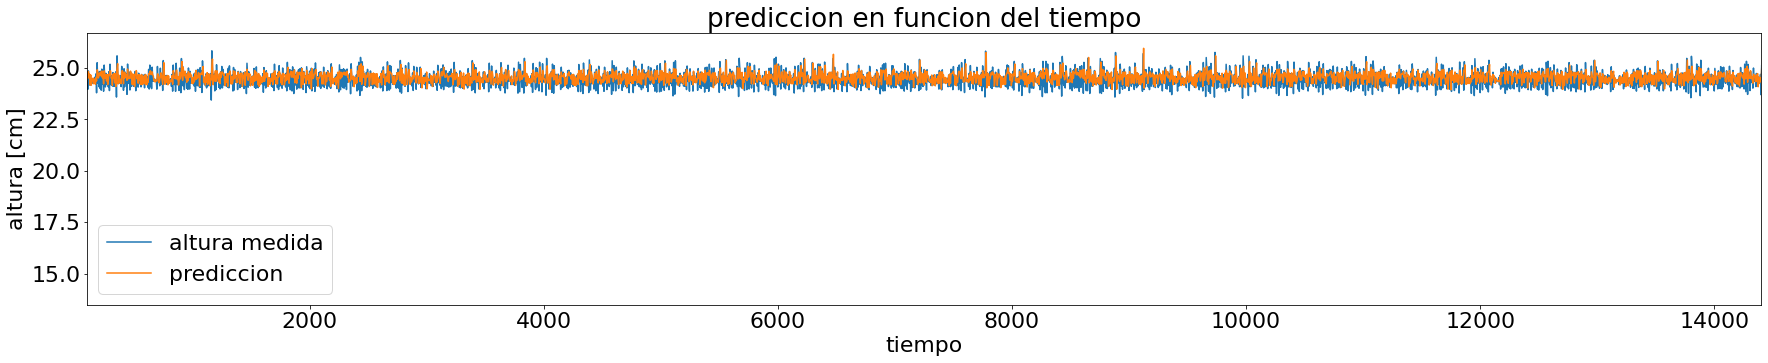

In [244]:
#plot prediction and reference
plt.figure(figsize=(30,5))
plt.plot(df_test['tiempo'][4:], df_test['hc'][4:], label='altura medida')
plt.plot(df_test['tiempo'], y_hat_1, label='prediccion')
# plt.plot(df_test['tiempo'], df_test['predicted_hc'], label='prediccion')
# plt.plot(df_test['tiempo'][4:], df_test['f_pid'][4:])
plt.legend()
plt.xlabel('tiempo')
plt.ylabel('altura [cm]')
plt.title('prediccion en funcion del tiempo')
plt.legend()
#draw vertical line in x = 3600
plt.axvline(x=36000, color='red', linestyle='--')
plt.xlim(100,len(df_test))

plt.show()


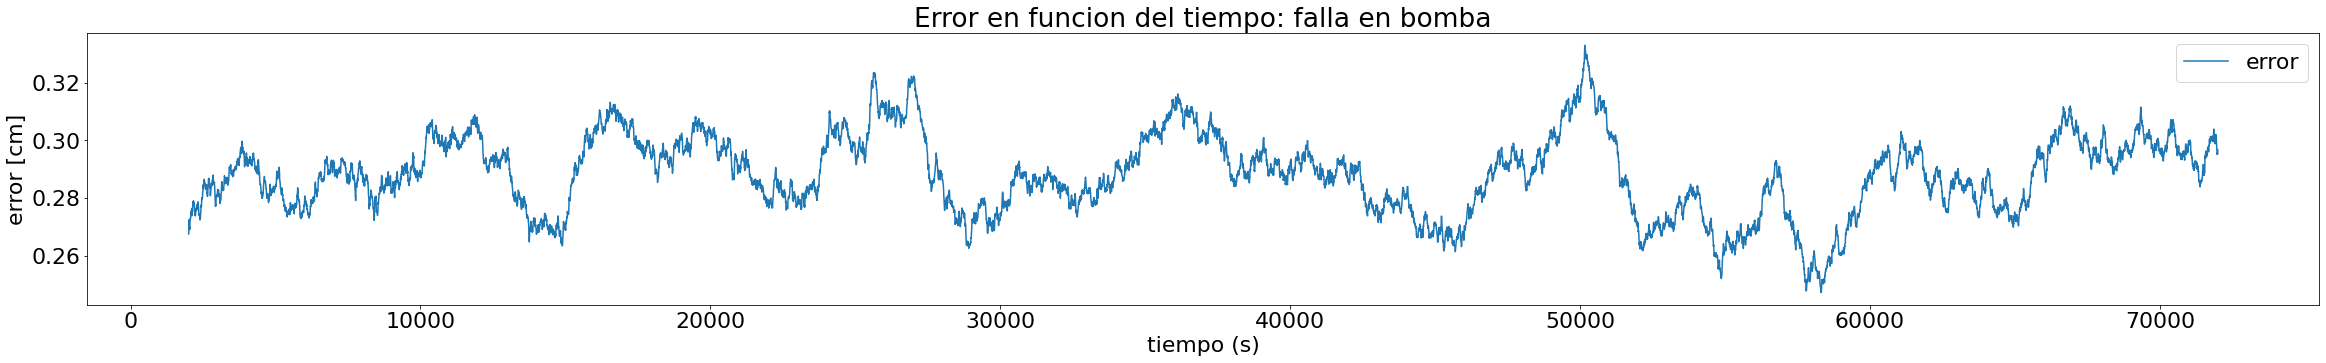

In [245]:
#plot error between prediction and reference
plt.figure(figsize=(40,5))
plt.plot(df_test['tiempo'], abs(y_hat_1 - df_test['hc']).rolling(400).mean(), label='error')
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error en funcion del tiempo: falla en {failure_location}')
# # draw vertical line in x = 3600 and 7200
# plt.axvline(x=36000, color='green', linestyle='--', label='inicio falla')
# plt.axvline(x=36000+3600, color='blue', linestyle='--', label='falla a 1 hora')
# plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='falla a 2 horas')
# plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='falla a 5 horas')
plt.legend()

plt.show()

In [242]:

#add y_hat_1 to df_test
df_test['y_hat_1'] = y_hat
df_test['error'] =  (df_test['hc'] - df_test['y_hat_1'])

#export df_test to csv
df_test.to_csv('..\outputs modelo\csv\out_sin_falla_t_continuo.csv')#f'..\outputs modelo\csv\out_falla_{failure_location}{data_version}.csv', index=False)

ValueError: Length of values (28801) does not match length of index (14401)

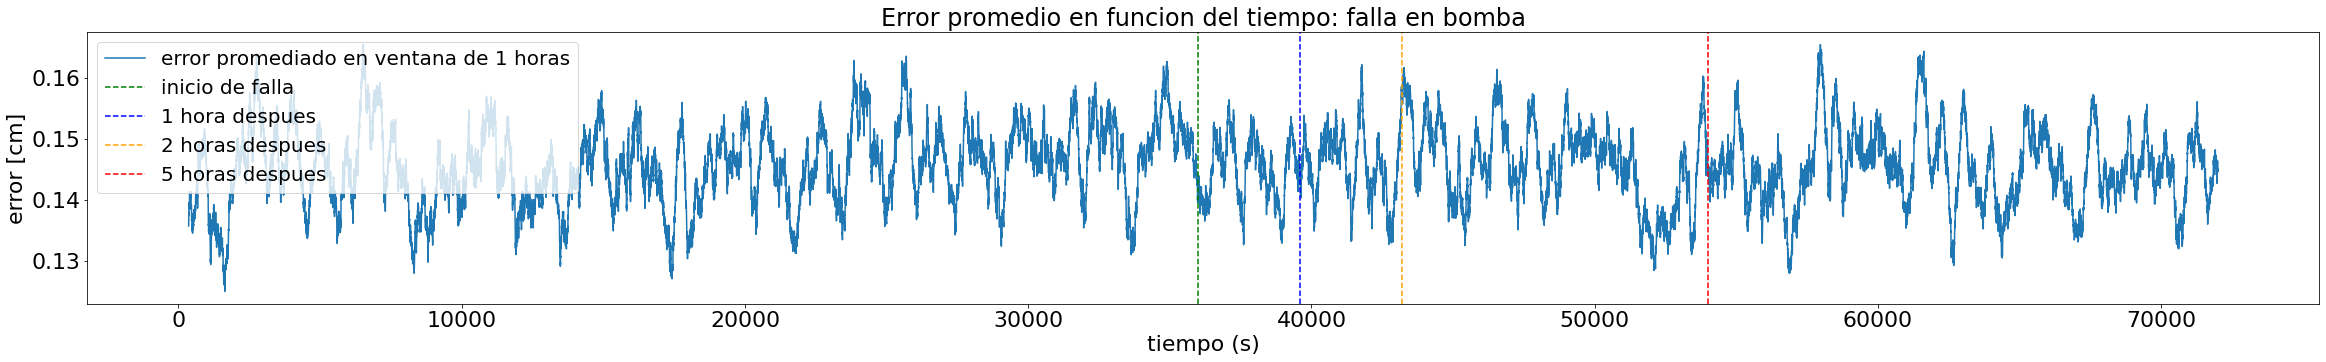

In [165]:
#plot mean error in a window of H hours sampling time

H = 1 #hours

plt.figure(figsize=(40,5))
# plt.plot(df_test['tiempo'], df_test['y_hat_1'] - df_test['hc'], label='error')
plt.plot(df_test['tiempo'],(abs(df_test['y_hat_1'] - df_test['hc'])).rolling(int(3600/10*H)).mean(), label=f'error promediado en ventana de {H} horas')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')
plt.title(f'Error promedio en funcion del tiempo: falla en {failure_location}')
# draw vertical line in x = 3600 and 7200
plt.axvline(x=36000, color='green', linestyle='--', label='inicio de falla')
plt.axvline(x=36000+3600, color='blue', linestyle='--', label='1 hora despues')
plt.axvline(x=36000+2*3600, color='orange', linestyle='--', label='2 horas despues')
plt.axvline(x=36000+5*3600, color='red', linestyle='--', label='5 horas despues')
plt.legend()
plt.show()


In [130]:
#save every column of df_test to numpy array
import os
failure_location = "fuga"
data_version =  "referencia_fija"
to_save = pd.read_csv(f'../outputs modelo/csv/out_falla_{failure_location}{data_version}.csv')

#create new directory to save numpy arrays
os.mkdir(f'../outputs modelo/npy/falla_{failure_location}{data_version}')

used_columns = ['tiempo', 'hc', 'f_pid', 'hc_prev', 'hc_prev_prev', 'freq_prev', 'y_hat_1', 'error']

for column in used_columns:
    np.save(f'../outputs modelo/npy/falla_{failure_location}{data_version}/{column}.npy', df_test[column].to_numpy())

# MODELO GENERADO POR EL SIMULINK

In [313]:
model_slx = pd.read_csv('../datos estanque/datos con falla/falla_fout_grave_t4s_long_v3.csv')[0:][::5]

model_slx.head()


,tiempo,referencia,hc,f_pid,predicted_hc
0,0,25,0.000001,0.000000,0.000001
5,5,25,0.164789,0.000000,0.000001
10,10,25,9.627392,56.806237,9.687627
15,15,25,10.657361,31.707123,10.479937
20,20,25,11.177591,34.609529,11.457559


In [314]:
#limit hc to live between 0 and 100
model_slx['hc'] = model_slx['hc'].clip(0,100)


In [315]:
#generate error signal of hc between oracle and model
error_signal = model_slx['hc'] - model_slx['predicted_hc']


Text(0, 0.5, 'error [cm]')

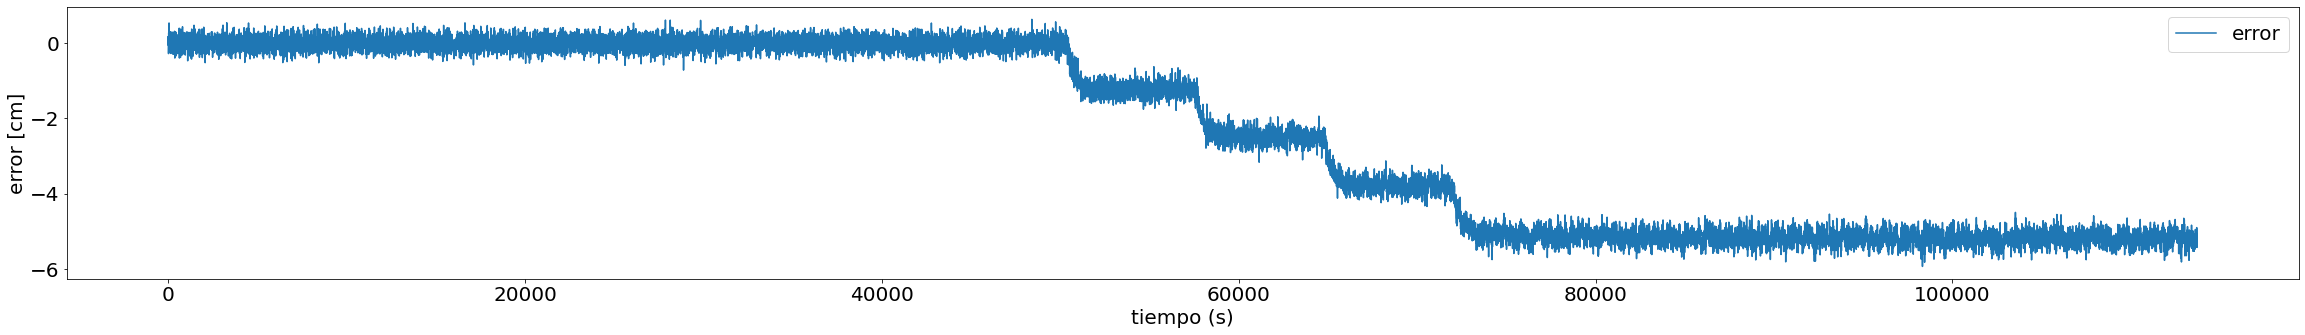

In [316]:
# plot error signal
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], error_signal ,label='error')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.xlabel('tiempo (s)')
plt.ylabel('error [cm]')


In [318]:
#calculate derivatives as hc_dot = (hc(t) - hc(t-1))/Ts
hc_dot = np.diff(model_slx['hc'])/5
hc_dot = np.insert(hc_dot, 0, 0)
#add hc_dot to model_slx
model_slx['hc_dot'] = hc_dot


In [319]:
np.insert(np.diff(np.array([1,2,3,4,5,6,7,8,9,10])), 0,0)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [320]:
#create predicted_hc_dot
predicted_hc_dot = np.diff(model_slx['predicted_hc'])/5
predicted_hc_dot = np.insert(predicted_hc_dot, 0, 0)
#add predicted_hc_dot to model_slx
model_slx['predicted_hc_dot'] = predicted_hc_dot


In [321]:
model_slx.tail(10)

,tiempo,referencia,hc,f_pid,predicted_hc,hc_dot,predicted_hc_dot
113675,113675,25,25.072137,36.909592,30.124018,0.022889,0.012129
113680,113680,25,25.137212,37.365082,30.197355,0.013015,0.014667
113685,113685,25,24.896285,36.517549,30.245671,-0.048185,0.009663
113690,113690,25,25.223128,30.495789,30.121079,0.065368,-0.024918
113695,113695,25,25.230536,40.400806,30.279227,0.001482,0.031630
113700,113700,25,24.888848,36.009556,30.312979,-0.068338,0.006750
113705,113705,25,24.705922,28.475171,30.130137,-0.036585,-0.036568
113710,113710,25,24.797491,30.215548,29.995493,0.018314,-0.026929
113715,113715,25,24.709499,35.860010,30.025286,-0.017598,0.005959
113720,113720,25,24.799893,33.278606,29.981874,0.018079,-0.008682


In [322]:
#generate same csv as previous with model_slx and error signal
model_slx['error'] = error_signal
# model_slx.to_csv('D:/Desktop/github memoria/modelos-estanque/outputs modelo/csv/out_falla_fout_5s_noint_slx.csv', index=False)


# ESTACIONARIDAD

In [3]:
# read exp_x.csv with x from 1 to 10 as dataframe from datos estanque\estacionaridad\exp_x.csv
dfs = {}
for i in range(1,11):
    dfs[i] = pd.read_csv(f'../datos estanque/estacionaridad/t1s/exp_{i}.csv')
    
 

In [4]:
dfs[10]

,tiempo,referencia,hc,f_pid,predicted_hc
0,0,25,0.000001,0.000000,0.000001
1,1,25,-0.002298,100.000000,0.000001
2,2,25,6.545464,100.000000,6.454067
3,3,25,9.043319,100.000000,9.250927
4,4,25,11.298538,100.000000,11.248088
...,...,...,...,...,...
35996,35996,25,24.980395,3.076255,24.684718
35997,35997,25,24.580731,45.940282,24.542286
35998,35998,25,24.465235,58.327229,24.634464
35999,35999,25,24.890010,12.770112,24.831272


In [6]:
# a_1 = 5.43
# a_2 = -78.23
# b = 20.21

# #calculate F_in and F_out
# for i in range(1,11):
#     dfs[i]['F_in'] = a_1*dfs[i]['hc'] + a_2*dfs[i]['hc'] + b*dfs[i]['f_pid']
#     dfs[i]['F_out'] = dfs[i]['F_in'] - dfs[i]['F']

In [41]:
tau = 36000-3600
t = 0
#calculate empirical corr
empirical_corr = []
for delta in range(0,tau):
    product = []
    for i in range(1,11):
        #normalized product by mean of f_pid
        norm_product = (dfs[i]['f_pid'][t+delta])*(dfs[i]['hc'][tau])
        product.append(norm_product)
    
    empirical_corr.append(np.array(product).sum()/10)


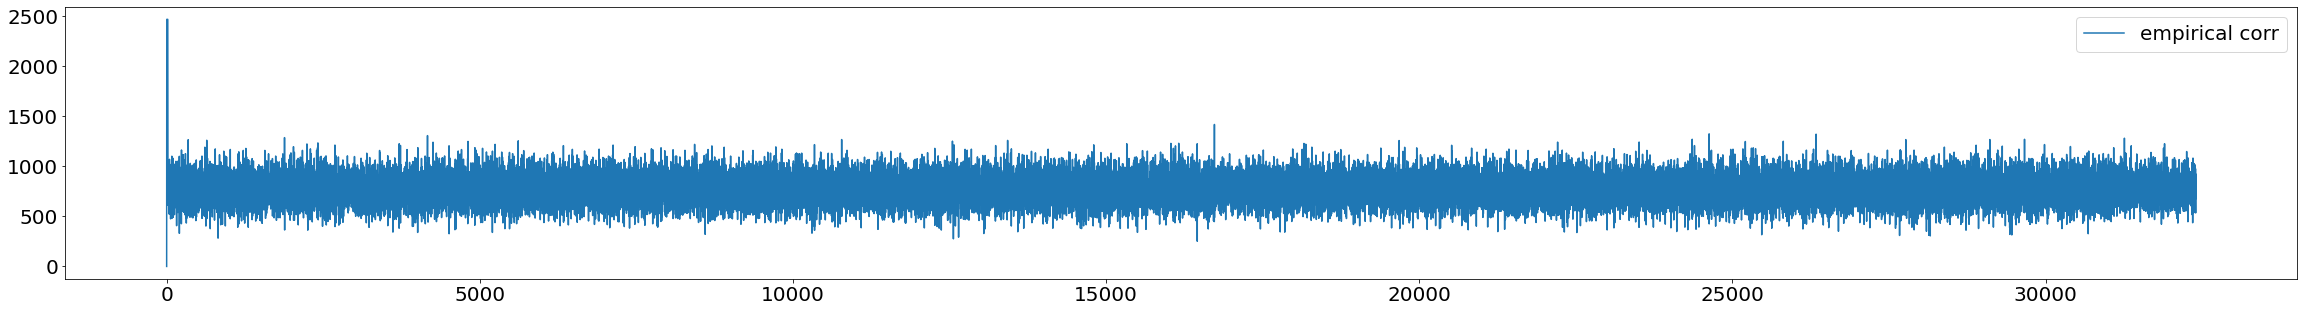

In [42]:
#plot empirical corr
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.show()

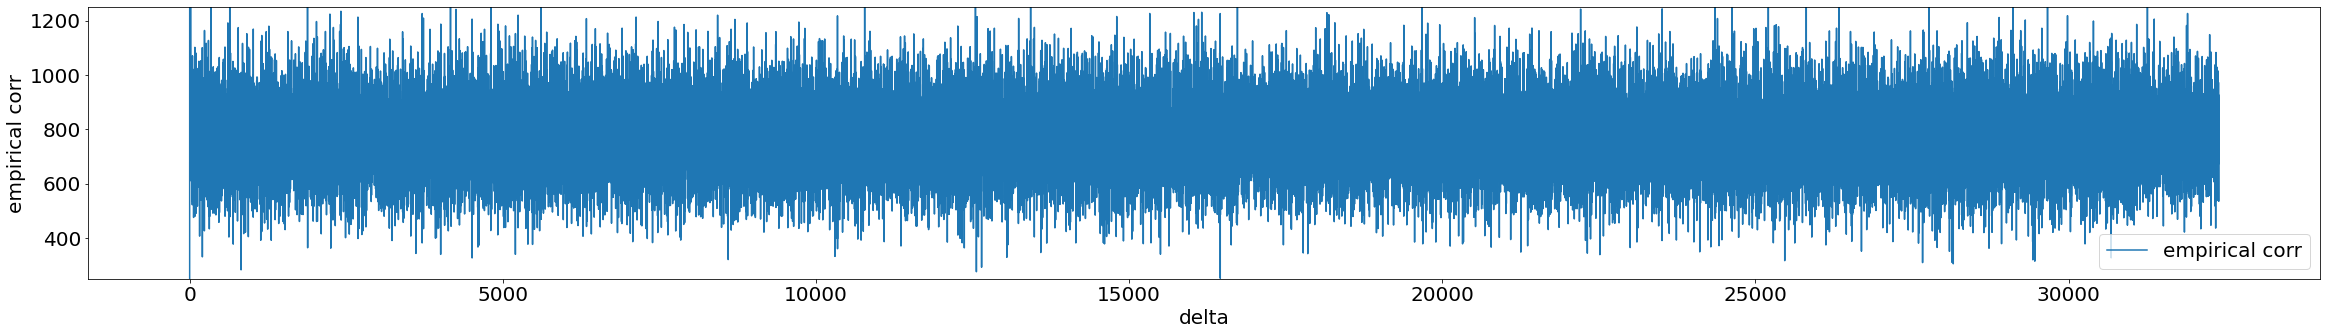

In [46]:
#zoom last graph to see better
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(250,1250)
plt.show()


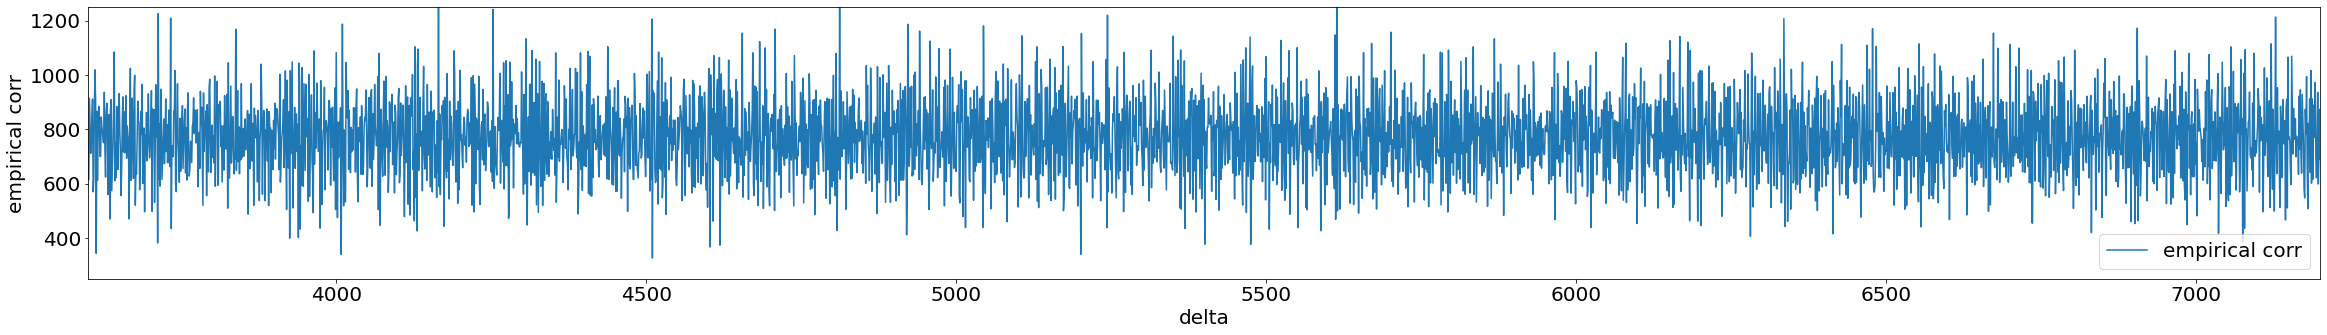

In [47]:
#window of 3600 samples in the prior plot
plt.figure(figsize=(40,5))
plt.plot(range(0,tau), empirical_corr, label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(250,1250)
plt.xlim(3600,7200)
plt.show()


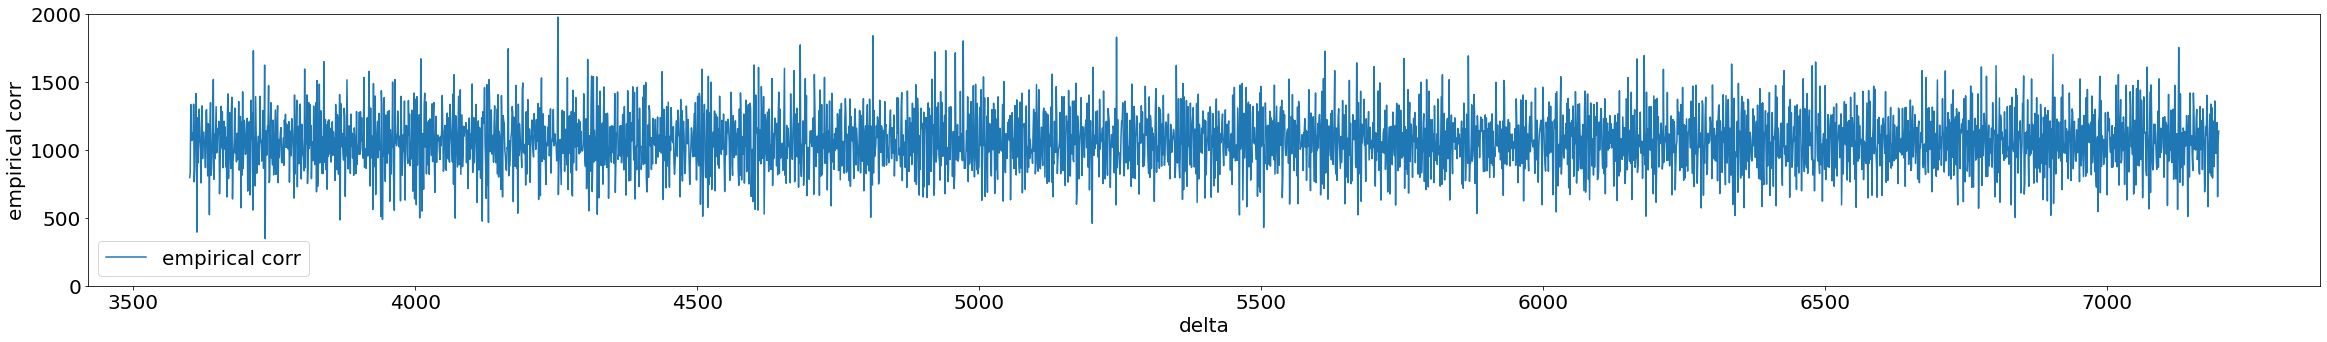

In [33]:
#window of 3600 samples of the prior graph
plt.figure(figsize=(40,5))
plt.plot(range(3600,7200), empirical_corr[3600:7200], label='empirical corr')
plt.ylabel('empirical corr')
plt.xlabel('delta')
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.ylim(0,2000)
plt.show()


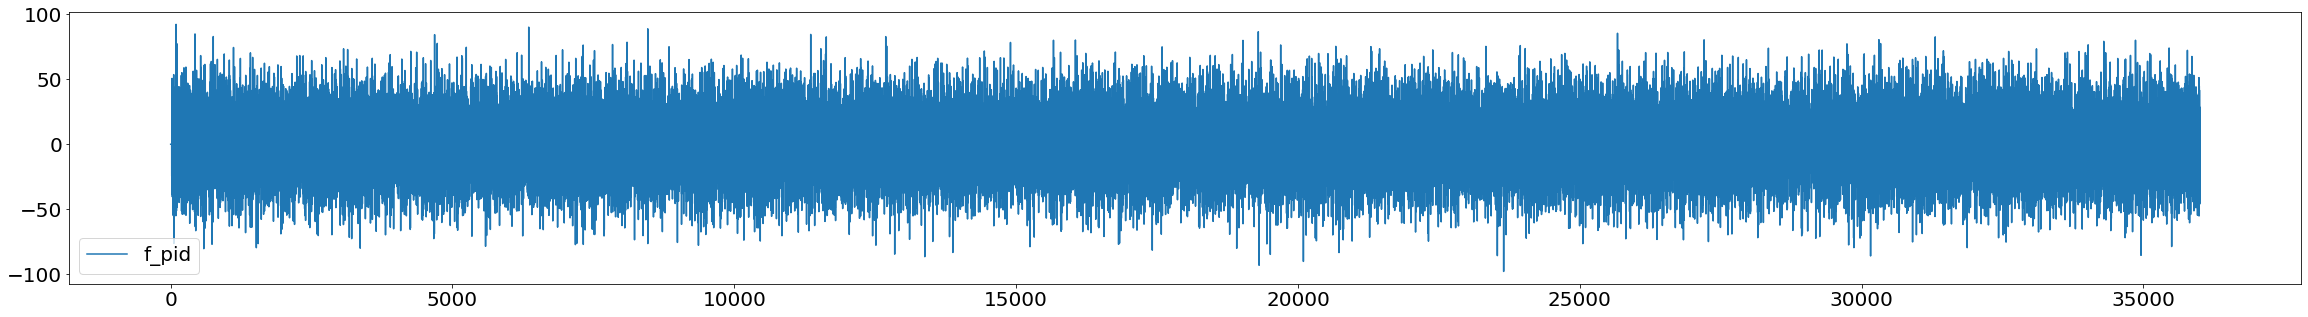

In [304]:
#plot disc variables
plt.figure(figsize=(40,5))
# plt.plot(df_1['tiempo'], disc['hc'], label='hc')
plt.plot(df_1['tiempo'], disc['f_pid'].rolling(1).mean(), label='f_pid')
# plt.plot(df_1['tiempo'], disc['predicted_hc'], label='predicted_hc')
# plt.rcParams.update({'font.size': 20})
plt.legend()

# TIMESERIES ANALYSIS

In [323]:
a_1 = 5.43
a_2 = -78.23
b = 20.21

#limit model_slx[hc] to the interval [0-100]
model_slx['hc'] = model_slx['hc'].clip(0,100)

#calculate F_in and F_out
F_in_hat = a_1*model_slx['f_pid'] + a_2
F_out = b*model_slx['hc']**0.5

F_out_hat = b*model_slx['predicted_hc']**0.5

#add F_in and F_out to model_slx
model_slx['F_in_hat'] = F_in_hat
model_slx['F_out'] = F_out
model_slx['F_out_hat'] = F_out_hat

In [324]:
#generate the residual signal
c1 = 0.63
c2 = 11.4
c3 = 17.1

#predicted f_in = predicted_hc_dot*(c1*predicted_hc**2 + c2*predicted_hc + c3)+predicted_f_out

f_in = model_slx['hc_dot']*(c1*model_slx['hc']**2 + model_slx['hc']*c2 + c3)+model_slx['F_out']
model_slx['F_in'] = f_in


#add residual signal to model_slx only using Fout
residual_signal = model_slx['F_out'] - model_slx['F_out_hat']

#add residual signal to model_slx
model_slx['residual'] = residual_signal


In [326]:
#estimate a1 from F_in 
a1_hat = (model_slx['F_in']-a_2)/model_slx['f_pid']


(-1.0, 100.0)

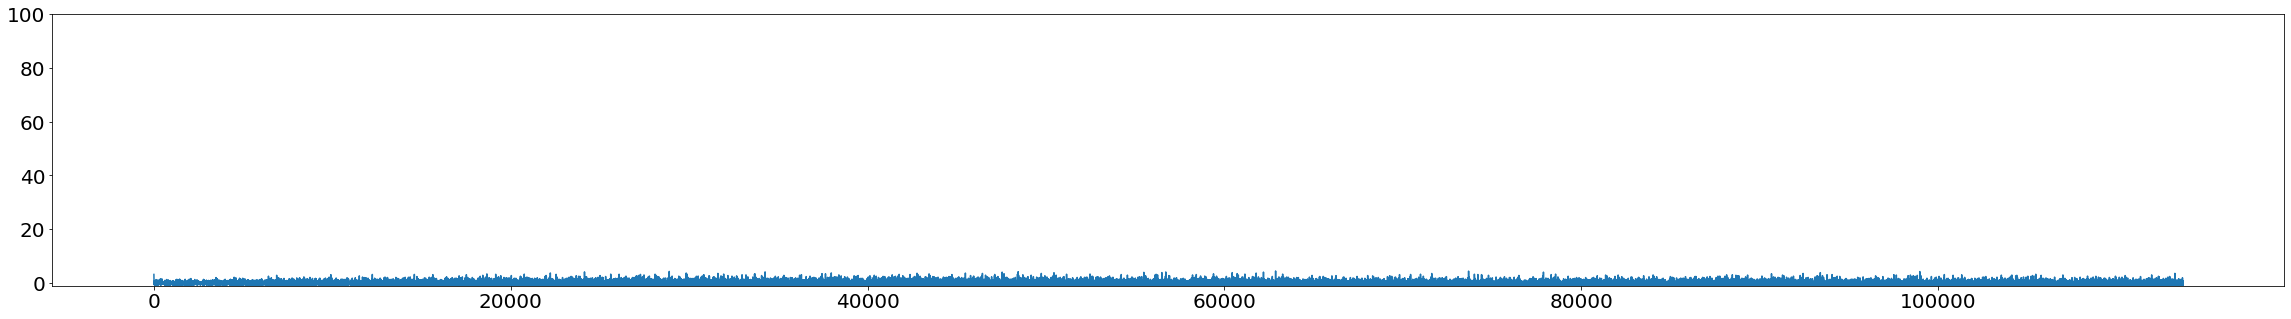

In [327]:
#plot a1_hat - a1
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], (a1_hat-a_1).rolling(1).mean(), label='a1_hat')
plt.ylim(-1,100)

Text(0.5, 0, 'tiempo (s)')

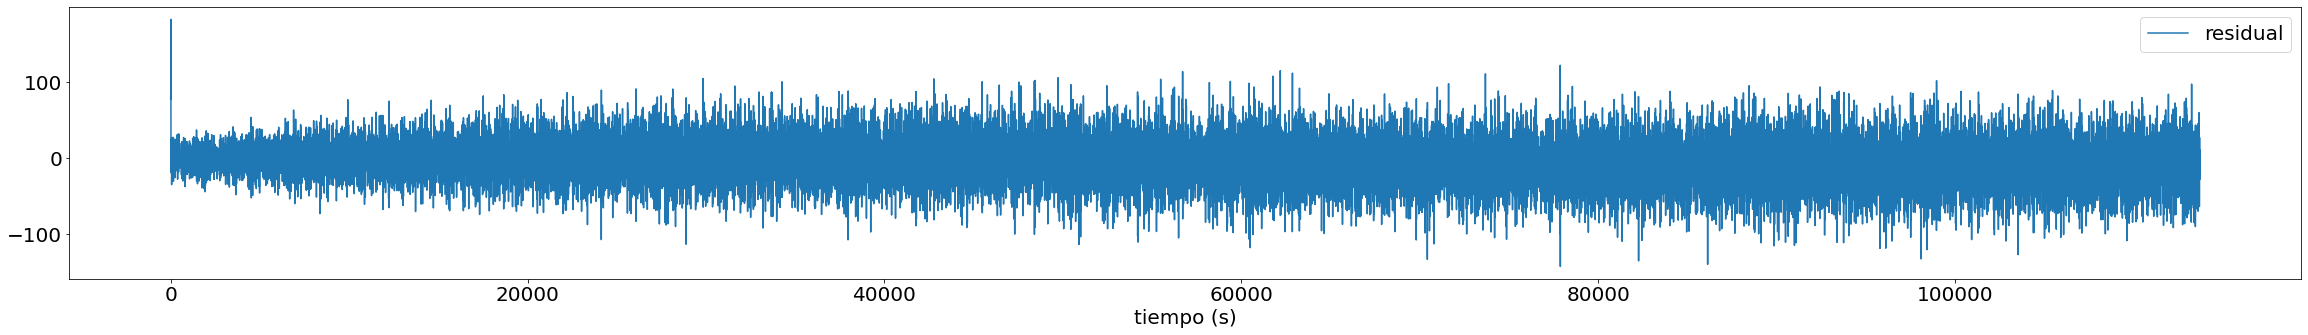

In [328]:
#plot fin - predicted_fin
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], (model_slx['F_in'] - model_slx['F_in_hat']).rolling(1).mean(), label='residual')
plt.rcParams.update({'font.size': 20})
plt.legend()
# plt.ylim(-0.5,0.5)
plt.xlabel('tiempo (s)')

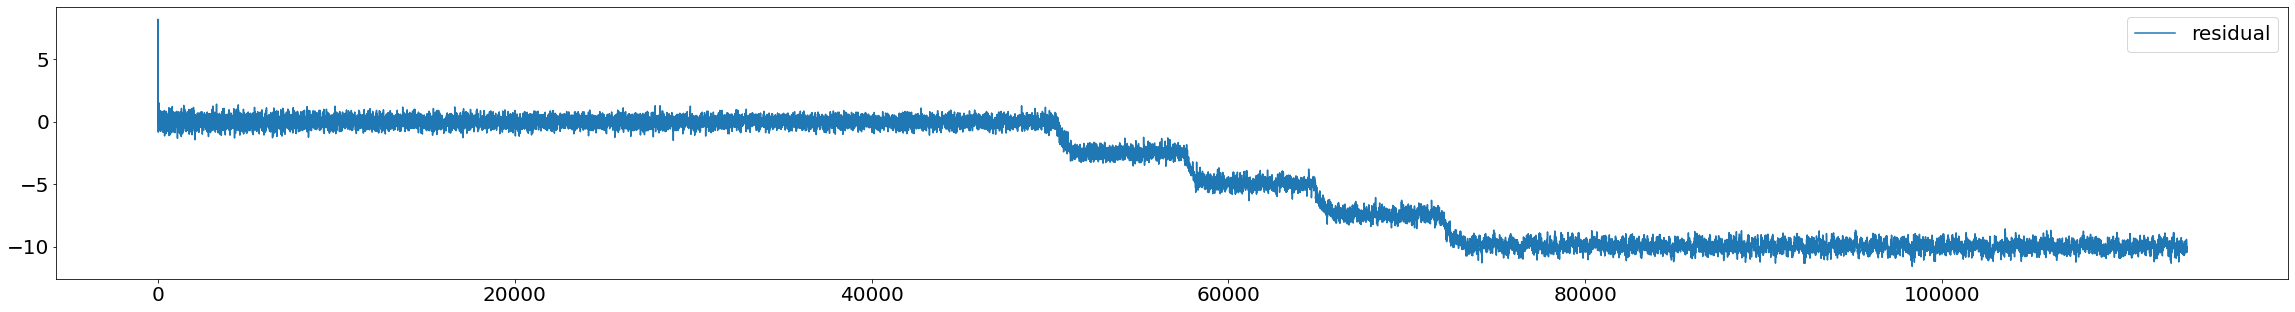

In [330]:
#plot residual signal
plt.figure(figsize=(40,5))
plt.plot(model_slx['tiempo'], model_slx['residual'].rolling(1).mean(), label='residual')
#limit y axis
# plt.ylim(-2,2)
plt.legend()

In [332]:
#extract the first 3600 and last 3600 samples of the residual signal in one dataframe
residual_signal = model_slx['residual'].copy()
residual_signal = residual_signal[0:3600].append(residual_signal[-3600:])

C:\Users\Joaquín\AppData\Local\Temp\ipykernel_21120\3635218094.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  residual_signal = residual_signal[0:3600].append(residual_signal[-3600:])


In [333]:
#export model_slx to csv
model_slx.to_csv('D:/Desktop/github memoria/modelos-estanque/outputs modelo/csv/out_falla_fout_5s_v7_slx.csv', index=False)

In [115]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

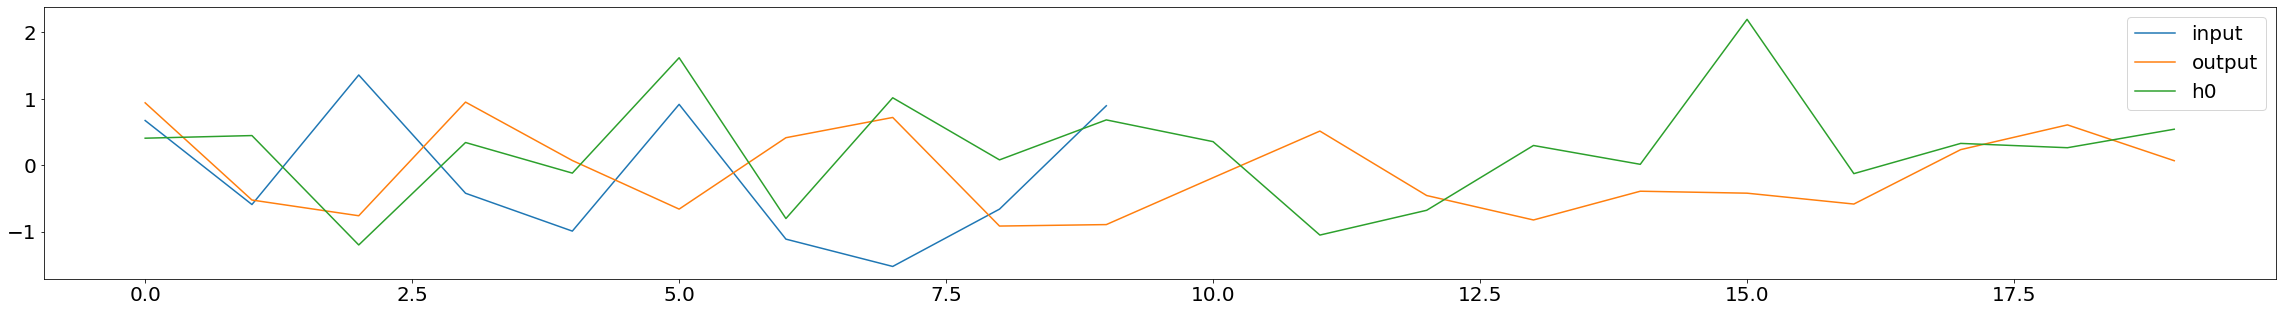

In [126]:
#plot input, h0 and output
plt.figure(figsize=(40,5))
plt.plot(input[0][0].detach().numpy(), label='input')
plt.plot(output[0][0].detach().numpy(), label='output')
plt.plot(h0[0][0].detach().numpy(), label='h0')

plt.legend()
